In [ ]:
# =========================================================
# Library Imports
# =========================================================

# ===== Basic Libraries =====
import numpy as np               # Numerical computations
import pandas as pd              # Data manipulation and analysis
import re                        # Regular expressions for text processing
import warnings                  # To manage and suppress warnings
from datetime import date        # Working with date objects
from tqdm import tqdm            # Progress bars for loops

# ===== Visualization =====
import matplotlib.pyplot as plt  # Core plotting library
import seaborn as sns            # Statistical data visualization

# ===== Statistics & Evaluation Metrics =====
from scipy.stats import spearmanr             # Spearman rank correlation (for IC calculation)
from sklearn.metrics import mean_squared_error, r2_score  # Model evaluation metrics

# ===== Feature Processing & Model Pipeline =====
from sklearn.impute import SimpleImputer               # Handle missing values
from sklearn.preprocessing import MaxAbsScaler, StandardScaler  # Data normalization
from sklearn.compose import ColumnTransformer          # Combine multiple preprocessing steps
from sklearn.pipeline import Pipeline                  # Build modeling pipelines
from sklearn.base import BaseEstimator, TransformerMixin  # Create custom transformers
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV  # Time-based CV and hyperparameter tuning

# ===== Modeling =====
import lightgbm as lgb              # LightGBM framework
from lightgbm import LGBMRegressor  # Core LightGBM model class

# ===== Optional Settings =====
warnings.filterwarnings("ignore")   # Suppress unnecessary warnings

1. Data Import & Preprocessing  
Ensure data cleaning, feature engineering, and time alignment with other models.

In [ ]:
# ------------------------------
# 0) 配置
# ------------------------------
file_path = "../data/final_df.csv"  
try:
    df_ori = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"*** ERROR: Cannot find {file_path} ***")

In [39]:
df = df_ori.copy()

# Sort by symbol and datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by=['symbol', 'datetime'])
df = df.reset_index(drop=True)

df['lret_1m'] = df.groupby('symbol')['close'].transform(lambda s: np.log(s).diff())
df['y_target'] = df.groupby('symbol')['lret_1m'].shift(-1)

initial_rows = len(df)
df = df[(df['y_target'].abs() <= 0.2)]
df = df.dropna(subset=['y_target', 'lret_1m'])

print(f"(Dropped {initial_rows - len(df)} unusal/NaN y value)")

# --- Re-sort by datatime, symbol ---
df = df.sort_values(by=['datetime', 'symbol'])
df = df.reset_index(drop=True)

df

(Dropped 12 unusal/NaN y value)


,datetime,symbol,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,f_minsin,f_mincos,...,split_nonpos_flag,shares_out,log_shares_out,eps_surp_pct_final,div_amount,log_shares_out_iqr_outlier,eps_estimate_rz_8,eps_actual,lret_1m,y_target
0,2024-04-30 12:51:00,AMAT,0,1,0,0,0,0,-0.220697,-0.975342,...,1,830897024,20.538016,0.00,0.0,0,0.0,0.00,-0.000199,-0.000100
1,2024-04-30 12:51:00,AMD,0,1,0,0,0,0,-0.220697,-0.975342,...,1,1616140032,21.203306,2.04,0.0,0,0.0,0.62,0.000314,-0.000126
2,2024-04-30 12:51:00,AVGO,0,1,0,0,0,0,-0.220697,-0.975342,...,1,465308000,19.958210,0.00,0.0,0,0.0,0.00,-0.000334,0.000721
3,2024-04-30 12:51:00,MU,0,1,0,0,0,0,-0.220697,-0.975342,...,1,1107369984,20.825254,0.00,0.0,0,0.0,0.00,0.000698,-0.000698
4,2024-04-30 12:51:00,NVDA,0,1,0,0,0,0,-0.220697,-0.975342,...,1,2500000000,21.639557,0.00,0.0,0,0.0,0.00,-0.000769,-0.000907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324883,2025-10-28 15:58:00,AMAT,0,1,0,0,0,0,-0.861629,-0.507538,...,1,796642427,20.495916,0.00,0.0,0,0.0,0.00,-0.000461,-0.000132
324884,2025-10-28 15:58:00,AMD,0,1,0,0,0,0,-0.861629,-0.507538,...,1,1633284837,21.213859,0.00,0.0,0,0.0,0.00,-0.000698,-0.001316
324885,2025-10-28 15:58:00,AVGO,0,1,0,0,0,0,-0.861629,-0.507538,...,1,4722365022,22.275576,0.00,0.0,0,0.0,0.00,0.000161,0.000375
324886,2025-10-28 15:58:00,MU,0,1,0,0,0,0,-0.861629,-0.507538,...,1,1122466035,20.838794,0.00,0.0,0,0.0,0.00,0.000270,-0.000135


In [45]:
y = df['y_target']
X = df.drop(columns=[
    'y_target', 'lret_1m', 'datetime', 'symbol',  
    'year', 'month', 'day', 'minute', 'minute_of_day'
], errors='ignore')

print(f"X original shape: {X.shape}")

# --- Find bad Cols with wrong data ---
desc = X.describe(percentiles=[0.99]).T
bad_cols = []

# std > 1000
bad_cols += desc.index[desc['std'] > 1e3].tolist()
# 99% > 1000
bad_cols += desc.index[desc['99%'].abs() > 1e3].tolist()
# Max > 1,000,000
bad_cols += desc.index[desc['max'].abs() > 1e6].tolist()
# Constant columns
bad_cols += desc.index[desc['std'] == 0].tolist()

bad_cols_set = sorted(set(bad_cols))
#print(f"--- Dropping {len(bad_cols_set)} bad cols ---")
#for col in bad_cols_set:
#   print(f"  - {col}")

# --- Drop bad cols ---
X_cleaned = X.drop(columns=bad_cols_set)

#print(f"\n--- X cleaned ---")
#print(f"X (cleaned) shape: {X_cleaned.shape}")

X original shape: (324888, 184)


In [ ]:
# ===== 3) 时序切分（前 2/3 训练 + 后 1/3 测试）=====
split_ratio = 1.0 / 1.5 
split_index = int(len(X_cleaned) * split_ratio)

X_val = X_cleaned.iloc[:split_index]
y_val = y.iloc[:split_index]

X_test = X_cleaned.iloc[split_index:]
y_test = y.iloc[split_index:]

print(f"--- Data Splitting done ---")
print(f" Validation set (X_val, y_val) shape: {X_val.shape}, {y_val.shape}")
print(f" Testing set (X_test, y_test) shape: {X_test.shape}, {y_test.shape}")

--- Data Splitting done ---
 Validation set (X_val, y_val) shape: (216592, 147), (216592,)
 Testing set (X_test, y_test) shape: (108296, 147), (108296,)


In [116]:
print("\n=== 时间范围 ===")
print(f"训练区间: {df.loc[X_train.index, 'datetime'].min()} → {df.loc[X_train.index, 'datetime'].max()}")
print(f"测试区间: {df.loc[X_test.index, 'datetime'].min()} → {df.loc[X_test.index, 'datetime'].max()}")


=== 时间范围 ===
训练区间: 2024-04-30 12:51:00 → 2025-04-29 15:59:00
测试区间: 2025-04-29 15:59:00 → 2025-10-28 15:58:00


2. Hyperparameter Tuning (All Features) — 10-Fold TimeSeriesSplit  
Focus: Full feature set with interpretable model diagnostics


In [ ]:
# ======================================================
# LightGBM — TimeSeriesSplit，对齐
# 口径：signals = sign(preds)；各折 pnl 串接；Sharpe = mean/std（未年化）
# ======================================================

# === 关闭无关警告 ===
warnings.filterwarnings("ignore", message="X does not have valid feature names.*")  # sklearn特征名告警
warnings.filterwarnings("ignore", category=UserWarning)  # 其它轻微warning

# --- Sharpe（未年化，Ridge 口径） ---
def sharpe_step_from_concat_pnl(pnl_series: pd.Series) -> float:
    std = pnl_series.std(ddof=1)
    return 0.0 if (std == 0 or np.isnan(std)) else pnl_series.mean() / std

# --- Ridge口径：逐样本 sign 仓位，不按时间聚合 ---
def fold_pnl_sign_no_agg(idx, y_true, y_pred):
    signals = np.sign(y_pred)
    return pd.Series(signals * y_true, index=idx)

# --- 参数列表 ---
param_list = [
    # 现有优胜附近的细化
    {"num_leaves": 63,  "min_child_samples": 40,  "subsample": 0.9, "colsample_bytree": 0.9, "reg_lambda": 1.0, "reg_alpha": 0.0},
    {"num_leaves": 63,  "min_child_samples": 60,  "subsample": 0.9, "colsample_bytree": 0.9, "reg_lambda": 1.0, "reg_alpha": 0.0},

    # 稍弱正则 + 稍强子采样
    {"num_leaves": 63,  "min_child_samples": 50,  "subsample": 0.8, "colsample_bytree": 0.8, "reg_lambda": 0.5, "reg_alpha": 0.0},
    {"num_leaves": 95,  "min_child_samples": 50,  "subsample": 0.8, "colsample_bytree": 0.8, "reg_lambda": 0.5, "reg_alpha": 0.0},

    # 更大叶子数但保持样本门槛，防过拟合
    {"num_leaves": 95,  "min_child_samples": 80,  "subsample": 0.9, "colsample_bytree": 0.9, "reg_lambda": 1.0, "reg_alpha": 0.0},

    # 轻微 L1（稀疏化）
    {"num_leaves": 63,  "min_child_samples": 50,  "subsample": 0.9, "colsample_bytree": 0.9, "reg_lambda": 1.0, "reg_alpha": 0.1},

    # 更强随机性（防泄漏/防过拟合）
    {"num_leaves": 63,  "min_child_samples": 50,  "subsample": 0.7, "colsample_bytree": 0.7, "reg_lambda": 1.0, "reg_alpha": 0.0},

    # 小步长 + 更多树，配合 early stopping（若你想加）
    # 这组在你的 Sharpe 外部选择下，early stopping 用 MSE 仅作为训练加速
    {"num_leaves": 63,  "min_child_samples": 50,  "subsample": 0.9, "colsample_bytree": 0.9, "reg_lambda": 1.0, "reg_alpha": 0.0,}
]

tscv = TimeSeriesSplit(n_splits=10)
results = []

for p in param_list:
    all_fold_pnl = []
    print(f"\n=== Testing params : {p} ===")

    for tr_idx, va_idx in tscv.split(X_val):
        X_tr, y_tr = X_val.iloc[tr_idx], y_val.iloc[tr_idx]
        X_va, y_va = X_val.iloc[va_idx], y_val.iloc[va_idx]

        # === 构建 Pipeline ===
        pipe = Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("reg", LGBMRegressor(
                objective="regression",
                n_estimators=1000,
                learning_rate=0.05,
                random_state=42,
                n_jobs=-1,                # 多核加速
                verbosity=-1,             # 关闭训练日志
                force_row_wise=True,      # 固定线程策略，消除 Info 提示
                **p
            ))
        ])

        pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict(X_va)

        # === Ridge口径：sign仓位 × 未年化 Sharpe ===
        fold_pnl = fold_pnl_sign_no_agg(X_val.index[va_idx], y_va.values, y_pred)
        all_fold_pnl.append(fold_pnl)

    # 各折 pnl 串接后算一次 Sharpe
    pnl_concat = pd.concat(all_fold_pnl).sort_index()
    sr_step = sharpe_step_from_concat_pnl(pnl_concat)

    results.append({
        "params": p,
        "Sharpe_step_concat": float(sr_step),
        "pnl_len": int(pnl_concat.size)
    })

# === 汇总输出 ===
cv_res = pd.DataFrame(results).sort_values("Sharpe_step_concat", ascending=False)
print("\n--- CV Result (per-step Sharpe, concat folds) ---")
print(cv_res[["params", "Sharpe_step_concat", "pnl_len"]])

best_params = cv_res.iloc[0]["params"]
print("\n✅ Best params by Ridge-style Sharpe:")
print(best_params)
print(f"Best per-step Sharpe = {cv_res.iloc[0]['Sharpe_step_concat']:.6f}")


=== Testing params : {'num_leaves': 63, 'min_child_samples': 40, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.0} ===

=== Testing params : {'num_leaves': 63, 'min_child_samples': 60, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.0} ===

=== Testing params : {'num_leaves': 63, 'min_child_samples': 50, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.0} ===

=== Testing params : {'num_leaves': 95, 'min_child_samples': 50, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.0} ===

=== Testing params : {'num_leaves': 95, 'min_child_samples': 80, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.0} ===

=== Testing params : {'num_leaves': 63, 'min_child_samples': 50, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.1} ===

=== Testing params : {'num_leaves': 63, 'min_child_samples': 50, 'subsample': 0.7, 'colsample_bytre

In [134]:
# ===== 终训（用最佳参数在 Train+Val 上回训） =====  # 你前面CV表里的最优参数
lgbm = LGBMRegressor(
    objective="regression",
    n_estimators=2000,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    verbosity=-1,
    force_row_wise=True,
    **best_params
)

# 确保是 DataFrame（避免特征名告警）
X_tr_fit = X_val.copy()
y_tr_fit = y_val.copy()

lgbm.fit(X_tr_fit, y_tr_fit)

# ===== 6) 特征重要性 =====
import pandas as pd

# 口径1：split（feature_importances_ 对应的是 split 次数）
imp_split = pd.Series(lgbm.feature_importances_, index=X_tr_fit.columns, name="split").sort_values(ascending=False)

# 口径2：gain（更能反映“平均增益”贡献）
booster = lgbm.booster_
gain_values = booster.feature_importance(importance_type="gain")
imp_gain = pd.Series(gain_values, index=booster.feature_name(), name="gain").sort_values(ascending=False)

In [135]:
gain_sorted = imp_gain.sort_values(ascending=False)
cum_gain_ratio = gain_sorted.cumsum() / gain_sorted.sum()

print("Top 20 features cumulative gain:", cum_gain_ratio.iloc[19])
print("Top 30 features cumulative gain:", cum_gain_ratio.iloc[29])
print("Top 50 features cumulative gain:", cum_gain_ratio.iloc[49])
print("Top 70 features cumulative gain:", cum_gain_ratio.iloc[69])

Top 20 features cumulative gain: 0.5315610159752362
Top 30 features cumulative gain: 0.6837867005236371
Top 50 features cumulative gain: 0.8625837482952752
Top 70 features cumulative gain: 0.9597528654899243


In [136]:
print("\nTop-75 Feature Importances (by GAIN):")
print(imp_gain.head(75).to_string())


Top-75 Feature Importances (by GAIN):
fz_spill_AMAT_lret_lag1     0.460616
minute_cos                  0.433020
fz_spill_NVDA_lret_lag1     0.370097
fz_spill_AVGO_lret_lag2     0.345362
fz_spill_AMD_lret_lag2      0.336435
fz_spill_AVGO_lret_lag1     0.330374
fz_spill_AMAT_lret_lag5     0.310017
fz_spill_AMD_lret_lag5      0.290954
fz_spill_AMAT_lret_lag2     0.272402
fz_spill_MU_lret_lag1       0.270703
fz_spill_NVDA_lret_lag4     0.262554
fz_spill_AMAT_lret_lag4     0.261023
fz_spill_NVDA_lret_lag2     0.248464
fz_spill_MU_lret_lag3       0.230317
fz_spill_AMD_lret_lag1      0.225698
fz_spill_AMAT_lret_lag3     0.217273
fz_spill_NVDA_lret_lag3     0.207888
close                       0.195898
f_volume_norm               0.186681
fz_lret_60_rolling          0.184610
f_minsin                    0.183053
fz_spill_MU_lret_lag5       0.178784
fz_spill_AMD_lret_lag4      0.178332
fz_lret_5_rolling           0.175118
vol_60                      0.173163
fz_spill_AVGO_lret_lag3     0.155230

3. Hyperparameter Tuning (Lasso-Selected 75 Features)  
Focus: Sparse feature subset from Lasso for efficient modeling

In [137]:
X_cleaned = X.drop(columns=bad_cols_set)

In [162]:
# 1) Lasso 选出的特征名单
LASSO_FEATURES = [
    "f_minsin","f_mincos","close","f_volume_norm","low","oc_change","rsi_14_clip","vol_60",
    "morning_tone_sum","mins_since_last_news","overnight_tone_mean","eps_estimate",
    "shares_out_roll_std_252","5d_before_earnings_flag","cnt_15m_is_zero","cnt_30m_is_zero",
    "cnt_60m_is_zero","dow_0","dow_1","dow_3","earnings_flag","f_volu_z_15_clipped",
    "f_volu_z_5_clipped","f_volu_z_60_clipped","fz_dev_close_ema200","fz_dev_close_vwap_15",
    "fz_dev_close_vwap_60","fz_dev_tp_ema20","fz_hl_over_atr20","fz_lret_15_rolling",
    "fz_lret_1_rolling","fz_lret_30_rolling","fz_lret_5_rolling","fz_lret_60_rolling",
    "fz_macd_hist","fz_rsi_pos","fz_spill_AMAT_lret_lag1","fz_spill_AMAT_lret_lag2",
    "fz_spill_AMAT_lret_lag3","fz_spill_AMAT_lret_lag4","fz_spill_AMAT_lret_lag5",
    "fz_spill_AMD_lret_lag1","fz_spill_AMD_lret_lag2","fz_spill_AMD_lret_lag3",
    "fz_spill_AMD_lret_lag4","fz_spill_AMD_lret_lag5","fz_spill_AVGO_lret_lag1",
    "fz_spill_AVGO_lret_lag2","fz_spill_AVGO_lret_lag4","fz_spill_AVGO_lret_lag5",
    "fz_spill_MU_lret_lag1","fz_spill_MU_lret_lag2","fz_spill_MU_lret_lag3",
    "fz_spill_MU_lret_lag4","fz_spill_MU_lret_lag5","fz_spill_NVDA_lret_lag1",
    "fz_spill_NVDA_lret_lag2","fz_spill_NVDA_lret_lag3","fz_spill_NVDA_lret_lag4",
    "fz_spill_NVDA_lret_lag5","fz_vol_15","fz_vol_30","fz_vol_5","fz_vol_60",
    "fz_vol_ratio_15","fz_vol_ratio_30","fz_vol_ratio_5","log_shares_out","minute_cos",
    "overnight_n_is_zero","shares_out_roll_z_252","split_mult","split_ratio","tone_sum",
    "volu_z_60"
]

# 2) 基于 X_cleaned 构建 X_lasso
present = [c for c in LASSO_FEATURES if c in X_cleaned.columns]
missing = [c for c in LASSO_FEATURES if c not in X_cleaned.columns]

if missing:
    print(f"⚠️ 有 {len(missing)} 个 Lasso 特征在 X_cleaned 中缺失（未纳入 X_lasso）:")
    for c in missing:
        print("   -", c)

X_lasso = X_cleaned.loc[:, present].copy()

# （可选）确保数值型（部分布尔/分类会在树模型里也可用，若你后续用线性模型建议转为数值）
# X_lasso = X_lasso.apply(pd.to_numeric, errors="ignore")

print(f"X_lasso 生成完成：形状 {X_lasso.shape}（包含 {len(present)} 个特征）")

X_lasso 生成完成：形状 (324888, 75)（包含 75 个特征）


In [139]:
# ===== 3) 时序切分（前 2/3 训练 + 后 1/3 测试）=====
split_ratio = 1.0 / 1.5 
split_index = int(len(X_lasso) * split_ratio)

X_val_lasso = X_lasso.iloc[:split_index]
y_val = y.iloc[:split_index]

X_test_lasso = X_lasso.iloc[split_index:]
y_test = y.iloc[split_index:]

print(f"--- Data Splitting done ---")
print(f" Validation set (X_val, y_val): {X_val_lasso.shape}, {y_val.shape}")
print(f" Testing set (X_test, y_test):   {X_test_lasso.shape}, {y_test.shape}")

--- Data Splitting done ---
 Validation set (X_val, y_val): (216592, 75), (216592,)
 Testing set (X_test, y_test):   (108296, 75), (108296,)


In [ ]:
# ======================================================
# LightGBM — TimeSeriesSplit，对齐
# 口径：signals = sign(preds)；各折 pnl 串接；Sharpe = mean/std（未年化）
# ======================================================

# === 关闭无关警告 ===
warnings.filterwarnings("ignore", message="X does not have valid feature names.*")  # sklearn特征名告警
warnings.filterwarnings("ignore", category=UserWarning)  # 其它轻微warning

# --- Sharpe（未年化，Ridge 口径） ---
def sharpe_step_from_concat_pnl(pnl_series: pd.Series) -> float:
    std = pnl_series.std(ddof=1)
    return 0.0 if (std == 0 or np.isnan(std)) else pnl_series.mean() / std

# --- Ridge口径：逐样本 sign 仓位，不按时间聚合 ---
def fold_pnl_sign_no_agg(idx, y_true, y_pred):
    signals = np.sign(y_pred)
    return pd.Series(signals * y_true, index=idx)

# --- 参数列表 ---
param_list = [
    # 现有优胜附近的细化
    {"num_leaves": 63,  "min_child_samples": 40,  "subsample": 0.9, "colsample_bytree": 0.9, "reg_lambda": 1.0, "reg_alpha": 0.0},
    {"num_leaves": 63,  "min_child_samples": 60,  "subsample": 0.9, "colsample_bytree": 0.9, "reg_lambda": 1.0, "reg_alpha": 0.0},

    # 稍弱正则 + 稍强子采样
    {"num_leaves": 63,  "min_child_samples": 50,  "subsample": 0.8, "colsample_bytree": 0.8, "reg_lambda": 0.5, "reg_alpha": 0.0},
    {"num_leaves": 95,  "min_child_samples": 50,  "subsample": 0.8, "colsample_bytree": 0.8, "reg_lambda": 0.5, "reg_alpha": 0.0},

    # 更大叶子数但保持样本门槛，防过拟合
    {"num_leaves": 95,  "min_child_samples": 80,  "subsample": 0.9, "colsample_bytree": 0.9, "reg_lambda": 1.0, "reg_alpha": 0.0},

    # 轻微 L1（稀疏化）
    {"num_leaves": 63,  "min_child_samples": 50,  "subsample": 0.9, "colsample_bytree": 0.9, "reg_lambda": 1.0, "reg_alpha": 0.1},

    # 更强随机性（防泄漏/防过拟合）
    {"num_leaves": 63,  "min_child_samples": 50,  "subsample": 0.7, "colsample_bytree": 0.7, "reg_lambda": 1.0, "reg_alpha": 0.0},

    # 小步长 + 更多树，配合 early stopping（若你想加）
    # 这组在你的 Sharpe 外部选择下，early stopping 用 MSE 仅作为训练加速
    {"num_leaves": 63,  "min_child_samples": 50,  "subsample": 0.9, "colsample_bytree": 0.9, "reg_lambda": 1.0, "reg_alpha": 0.0,}
]

tscv = TimeSeriesSplit(n_splits=10)
results = []

for p in param_list:
    all_fold_pnl = []
    print(f"\n=== Testing params: {p} ===")

    for tr_idx, va_idx in tscv.split(X_val_lasso):
        X_tr, y_tr = X_val_lasso.iloc[tr_idx], y_val.iloc[tr_idx]
        X_va, y_va = X_val_lasso.iloc[va_idx], y_val.iloc[va_idx]

        # === 构建 Pipeline ===
        pipe = Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("reg", LGBMRegressor(
                objective="regression",
                n_estimators=1000,
                learning_rate=0.05,
                random_state=42,
                n_jobs=-1,                # 多核加速
                verbosity=-1,             # 关闭训练日志
                force_row_wise=True,      # 固定线程策略，消除 Info 提示
                **p
            ))
        ])

        pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict(X_va)

        # === Ridge口径：sign仓位 × 未年化 Sharpe ===
        #fold_pnl = fold_pnl_sign_no_agg(X_val_lasso.index[va_idx], y_va.values, y_pred)
        fold_pnl = fold_pnl_sign_no_agg(X_va.index, y_va.values, y_pred)
        all_fold_pnl.append(fold_pnl)

    # 各折 pnl 串接后算一次 Sharpe
    pnl_concat = pd.concat(all_fold_pnl).sort_index()
    sr_step = sharpe_step_from_concat_pnl(pnl_concat)

    results.append({
        "params": p,
        "Sharpe_step_concat": float(sr_step),
        "pnl_len": int(pnl_concat.size)
    })

# === 汇总输出 ===
cv_res = pd.DataFrame(results).sort_values("Sharpe_step_concat", ascending=False)
print("\n--- CV Result (per-step Sharpe, concat folds) ---")
print(cv_res[["params", "Sharpe_step_concat", "pnl_len"]])

best_params = cv_res.iloc[0]["params"]
#Best params by Ridge-style Sharpe:
print("\nBest params by Sharpe:")
print(best_params)
print(f"Best per-step Sharpe = {cv_res.iloc[0]['Sharpe_step_concat']:.6f}")


=== Testing params: {'num_leaves': 63, 'min_child_samples': 40, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.0} ===

=== Testing params: {'num_leaves': 63, 'min_child_samples': 60, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.0} ===

=== Testing params: {'num_leaves': 63, 'min_child_samples': 50, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.0} ===

=== Testing params: {'num_leaves': 95, 'min_child_samples': 50, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.0} ===

=== Testing params: {'num_leaves': 95, 'min_child_samples': 80, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.0} ===

=== Testing params: {'num_leaves': 63, 'min_child_samples': 50, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.1} ===

=== Testing params: {'num_leaves': 63, 'min_child_samples': 50, 'subsample': 0.7, 'colsample_bytree': 0.7

4. Rolling Window Backtesting (Test Set, 30-Minute Horizon)  
Focus: Out-of-sample evaluation with dynamic re-training

In [ ]:
# ===== 0) Configuration =====
ROLLING_WINDOW_MINUTES = 30

BEST_PARAMS_LGBM = {  # Best parameters from CV
    "num_leaves": 63,
    "min_child_samples": 50,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "reg_lambda": 1.0,
    "reg_alpha": 0.0,
}

def build_lgbm_pipe(best_params=BEST_PARAMS_LGBM):
    return Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("reg", LGBMRegressor(
            objective="regression",
            n_estimators=1000,
            learning_rate=0.05,
            random_state=42,
            n_jobs=-1,
            verbosity=-1,
            force_row_wise=True,
            **best_params
        ))
    ])

def sharpe_per_step(series: pd.Series) -> float:
    std = series.std(ddof=1)
    return 0.0 if (std == 0 or np.isnan(std)) else series.mean() / std

In [144]:
# ===== 1) Prepare backtest data =====
df_backtest = df.set_index('datetime')

test_original_indices = X_test_lasso.index
test_datetimes = np.sort(df.loc[test_original_indices, 'datetime'].unique())

feature_cols = list(X_val_lasso.columns)
available_cols = [c for c in feature_cols if c in df_backtest.columns]
if len(available_cols) < len(feature_cols):
    miss = sorted(set(feature_cols) - set(available_cols))
    print(f"⚠️ Missing {len(miss)} Lasso features: {miss[:10]}{' ...' if len(miss)>10 else ''}")

X_full_history = df_backtest[available_cols]
y_full_history = df_backtest['y_target']
meta_full_history = df_backtest[['symbol']]

print(f"--- Starting minute-level rolling backtest (LGBM + Lasso) ---")
print(f"Testing period: {test_datetimes.min()} → {test_datetimes.max()}")
print(f"Rolling window (training): {ROLLING_WINDOW_MINUTES} minutes")
print(f"LightGBM best parameters: {BEST_PARAMS_LGBM}")

--- Starting minute-level rolling backtest (LGBM + Lasso) ---
Testing period: 2025-04-29T15:59:00.000000000 → 2025-10-28T15:58:00.000000000
Rolling window (training): 30 minutes
LightGBM best parameters: {'num_leaves': 63, 'min_child_samples': 50, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.0}


In [145]:
# ===== 2) Rolling window: [t-30m, t-1m] → predict t =====
results = []

for current_dt in tqdm(test_datetimes):
    train_start_dt = current_dt - pd.Timedelta(minutes=ROLLING_WINDOW_MINUTES)
    train_end_dt   = current_dt - pd.Timedelta(minutes=1)

    # Training window
    X_tr = X_full_history.loc[train_start_dt:train_end_dt]
    y_tr = y_full_history.loc[train_start_dt:train_end_dt]

    if len(X_tr) < 15 * 5:
        continue

    # Test data at current minute
    X_te = X_full_history.loc[current_dt]
    if isinstance(X_te, pd.Series):
        X_te = X_te.to_frame().T

    pipe = build_lgbm_pipe()
    pipe.fit(X_tr, y_tr)
    y_hat = pipe.predict(X_te)

    meta_rows = meta_full_history.loc[current_dt]
    y_true = y_full_history.loc[current_dt]

    if isinstance(meta_rows, pd.Series):
        results.append({
            "datetime": current_dt,
            "symbol": meta_rows['symbol'],
            "predicted_log_return": float(y_hat[0]),
            "actual_log_return": float(y_true),
        })
    else:
        for i in range(len(meta_rows)):
            results.append({
                "datetime": current_dt,
                "symbol": meta_rows.iloc[i]['symbol'],
                "predicted_log_return": float(y_hat[i]),
                "actual_log_return": float(y_true.iloc[i]),
            })

100%|██████████| 21660/21660 [1:05:00<00:00,  5.55it/s]


In [146]:
# ===== 3) Post-processing: derived columns =====
results_df = pd.DataFrame(results).sort_values(["datetime","symbol"]).reset_index(drop=True)

# (A) Long-only relative weights (sum=1 per minute)
results_df["positive_prediction"] = results_df["predicted_log_return"].clip(lower=0)
minute_sum = results_df.groupby("datetime")["positive_prediction"].transform("sum")
results_df["weight_relative"] = np.where(minute_sum == 0, 0.0,
                                         results_df["positive_prediction"] / minute_sum)
results_df.drop(columns=["positive_prediction"], inplace=True)

# (B) Sign weights (-1/0/+1)
results_df["weight_sign"] = np.sign(results_df["predicted_log_return"])

# (C) Per-sample PnL (sign-based, same as CV)
results_df["pnl_sample_sign"] = results_df["weight_sign"] * results_df["actual_log_return"]

# (D) Long-only PnL (relative weights)
results_df["pnl_sample_relative"] = results_df["weight_relative"] * results_df["actual_log_return"]

# (E) Aggregate by minute (optional)
pnl_minute_sign = results_df.groupby("datetime")["pnl_sample_sign"].mean()
pnl_minute_relative = results_df.groupby("datetime")["pnl_sample_relative"].sum()

print("\n--- Backtesting completed ---")
print(f"Total backtest rows: {len(results_df)}")
print(results_df.head())


--- Backtesting completed ---
Total backtest rows: 99749
             datetime symbol  predicted_log_return  actual_log_return  \
0 2025-04-29 15:59:00   AMAT             -0.000121          -0.014007   
1 2025-04-29 15:59:00    AMD             -0.000194          -0.006581   
2 2025-04-29 15:59:00   AVGO             -0.000019          -0.008008   
3 2025-04-29 15:59:00     MU              0.000106          -0.019444   
4 2025-04-29 15:59:00   NVDA              0.000160          -0.025525   

   weight_relative  weight_sign  pnl_sample_sign  pnl_sample_relative  
0          0.00000         -1.0         0.014007            -0.000000  
1          0.00000         -1.0         0.006581            -0.000000  
2          0.00000         -1.0         0.008008            -0.000000  
3          0.39797          1.0        -0.019444            -0.007738  
4          0.60203          1.0        -0.025525            -0.015367  


In [147]:
# ===== 4) OOS evaluation metrics =====
y_true_all = results_df["actual_log_return"].values
y_pred_all = results_df["predicted_log_return"].values

mse = mean_squared_error(y_true_all, y_pred_all)
r2  = r2_score(y_true_all, y_pred_all)
ic  = spearmanr(y_true_all, y_pred_all)[0]

sr_step_sign_samples   = sharpe_per_step(results_df["pnl_sample_sign"])         
sr_step_sign_minutes   = sharpe_per_step(pnl_minute_sign)                        
sr_step_relative_minutes = sharpe_per_step(pnl_minute_relative)                  

print("\n=== [OOS • Test Split] Performance ===")
print(f"MSE                         : {mse:.8f}")
print(f"R²                          : {r2:.6f}")
print(f"IC (Spearman ρ)             : {ic:.6f}")
print(f"Sharpe (per-step, sign) — sample-level : {sr_step_sign_samples:.6f}  (same CV style)")
print(f"Sharpe (per-step, sign) — minute-level : {sr_step_sign_minutes:.6f}  (portfolio level)")
print(f"Sharpe (per-step, long-only relative)  : {sr_step_relative_minutes:.6f}  (portfolio level)")


=== [OOS • Test Split] Performance ===
MSE                         : 0.00000472
R²                          : -0.031999
IC (Spearman ρ)             : 0.003654
Sharpe (per-step, sign) — sample-level : -0.005751  (same CV style)
Sharpe (per-step, sign) — minute-level : -0.008788  (portfolio level)
Sharpe (per-step, long-only relative)  : 0.010786  (portfolio level)


In [148]:
# ===== 5) Export results =====

# (A) Full detailed results (minute × symbol × predictions)
results_path = "lightgbm_result_full.csv"
results_df.to_csv(results_path, index=False)
print(f"\n✅ Full detailed results saved to: {results_path}")

# (B) Summary metrics (OOS performance)
summary_dict = {
    "MSE": mse,
    "R2": r2,
    "IC_Spearman": ic,
    "Sharpe_per_step_sign_sample": sr_step_sign_samples,
    "Sharpe_per_step_sign_minute": sr_step_sign_minutes,
    "Sharpe_per_step_relative_minute": sr_step_relative_minutes,
    "num_rows": len(results_df)
}

summary_df = pd.DataFrame([summary_dict])
summary_path = "lightgbm_result_summary.csv"
summary_df.to_csv(summary_path, index=False)
print(f"✅ Summary metrics saved to: {summary_path}")


✅ Full detailed results saved to: lightgbm_result_full.csv
✅ Summary metrics saved to: lightgbm_result_summary.csv


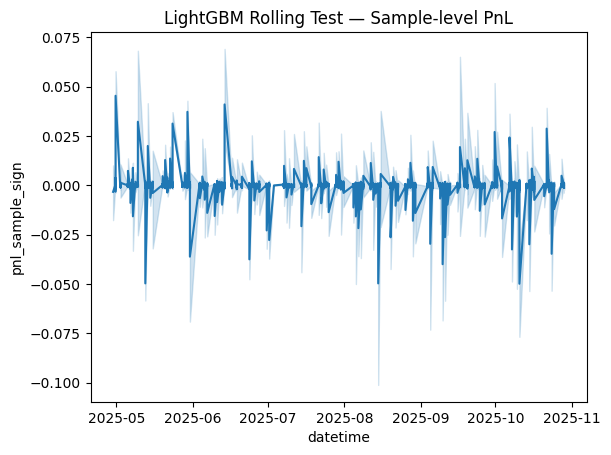

In [ ]:
sns.lineplot(x="datetime", y="pnl_sample_sign", data=results_df)
plt.title("LightGBM Rolling Test — Sample-level PnL")
plt.show()

5. Overfitting Diagnostics & Model Stability Check  
Focus: Evaluate generalization, rolling IC, and Sharpe consistency

In [ ]:
df_eval = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred_test
}, index=X_test.index)   # 若不是 DatetimeIndex，可先： df_eval.index = pd.to_datetime(df_eval.index)
df_eval = df_eval.sort_index()

In [ ]:
# ======================================================
# Evaluation from df_results (NO retraining required)
# Expect df_results has columns: ["datetime","symbol","predicted_log_return","actual_log_return"]
# ======================================================

# ------------- 0) 基础准备：清洗 & 排序 -------------
df = results_df.copy()  # <- 你已有的滚动预测输出
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values(["datetime", "symbol"]).reset_index(drop=True)

# 可选：如果你的 y 是 log-return，名称更语义化：
df = df.rename(columns={
    "predicted_log_return": "y_pred",
    "actual_log_return": "y_true"
})

In [155]:
# ------------- 1) 基础静态指标（整体 OOS）-------------
# 说明：这里把“每一行”当作一个独立样本（无论是何股票、何分钟）
mse = mean_squared_error(df["y_true"], df["y_pred"])
r2  = r2_score(df["y_true"], df["y_pred"])
ic_overall = spearmanr(df["y_true"], df["y_pred"]).correlation

print("=== [Overall OOS] ===")
print(f"MSE : {mse:.8f}")
print(f"R²  : {r2:.6f}")
print(f"IC  : {ic_overall:.6f}")

=== [Overall OOS] ===
MSE : 0.00000472
R²  : -0.031999
IC  : 0.003654


In [156]:
# ------------- 2) 年化系数设置（分钟级场景）-------------
# 若是美股 1min 频：每天约 390 根，全年约 252 天
STEPS_PER_DAY = 390
TRADING_DAYS_PER_YEAR = 252
ANNUALIZATION = np.sqrt(STEPS_PER_DAY * TRADING_DAYS_PER_YEAR)

# 如果是 5min 频，把 STEPS_PER_DAY 改成 78 即可：
# STEPS_PER_DAY = 78
# ANNUALIZATION = np.sqrt(STEPS_PER_DAY * TRADING_DAYS_PER_YEAR)

In [157]:
# ------------- 3) 两类 PnL 与 Sharpe -------------
# A) sign-based 策略：按方向做多做空（对每条记录/每支股票/每分钟）
df["pnl_sign"] = np.sign(df["y_pred"]) * df["y_true"]

def sharpe_per_step(x: pd.Series) -> float:
    std = x.std()
    return 0.0 if (std is None or std == 0) else x.mean() / std

# A1) “样本级”Sharpe（逐条记录）
sharpe_sign_sample = sharpe_per_step(df["pnl_sign"])
sharpe_sign_sample_ann = sharpe_sign_sample * ANNUALIZATION

# A2) “分钟级组合”Sharpe：同一分钟内对多只股票等权聚合，再算 Sharpe（更接近组合表现）
pnl_sign_minute = df.groupby("datetime")["pnl_sign"].mean()
sharpe_sign_minute = sharpe_per_step(pnl_sign_minute)
sharpe_sign_minute_ann = sharpe_sign_minute * ANNUALIZATION

print("\n=== [Sharpe • sign] ===")
print(f"Per-step (sample-level): {sharpe_sign_sample:.6f} | annualized: {sharpe_sign_sample_ann:.6f}")
print(f"Per-step (minute-level portfolio): {sharpe_sign_minute:.6f} | annualized: {sharpe_sign_minute_ann:.6f}")

# B) long-only relative：仅做“预测值 Top X%”的多头，其他股票当期空仓（按分钟横截面挑选）
TOP_Q = 0.7  # 取前 30%（可改成 0.8 表示前 20%）
def minute_long_only_return(g: pd.DataFrame, q=TOP_Q) -> float:
    if g.empty:
        return np.nan
    cutoff = g["y_pred"].quantile(q)
    pick = g.loc[g["y_pred"] >= cutoff, "y_true"]
    return np.nan if pick.empty else pick.mean()

# 逐“分钟横截面”挑选 top 分位多头，得到分钟级收益时间序列
pnl_lo_minute = df.groupby("datetime").apply(minute_long_only_return)
pnl_lo_minute = pnl_lo_minute.dropna()

sharpe_lo = sharpe_per_step(pnl_lo_minute)
sharpe_lo_ann = sharpe_lo * ANNUALIZATION

print("\n=== [Sharpe • long-only relative] ===")
print(f"Per-step (minute-level, top {int((1-TOP_Q)*100)}% long-only): {sharpe_lo:.6f} | annualized: {sharpe_lo_ann:.6f}")


=== [Sharpe • sign] ===
Per-step (sample-level): -0.005751 | annualized: -1.802984
Per-step (minute-level portfolio): -0.008788 | annualized: -2.754892

=== [Sharpe • long-only relative] ===
Per-step (minute-level, top 30% long-only): 0.020691 | annualized: 6.486698


/var/folders/zf/ww_jwg316dg_dv_w2tvgfcxw0000gn/T/ipykernel_78444/2338418822.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pnl_lo_minute = df.groupby("datetime").apply(minute_long_only_return)


In [158]:
# ------------- 4) 横截面 IC（更适合截面选股/因子）-------------
# 思路：对每一个“时间截面（同一分钟）”，在多只股票上计算 Spearman 相关；
# 得到一条“CS-IC 随时间的序列”，再做滚动平均/可视化。
def cs_ic_per_minute(g: pd.DataFrame) -> float:
    # 至少需要 2 支股票才能算秩相关
    if len(g) < 2:
        return np.nan
    return spearmanr(g["y_true"], g["y_pred"]).correlation

ic_cs_series = df.groupby("datetime").apply(cs_ic_per_minute).dropna()

/var/folders/zf/ww_jwg316dg_dv_w2tvgfcxw0000gn/T/ipykernel_78444/3113149841.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(g["y_true"], g["y_pred"]).correlation
/var/folders/zf/ww_jwg316dg_dv_w2tvgfcxw0000gn/T/ipykernel_78444/3113149841.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ic_cs_series = df.groupby("datetime").apply(cs_ic_per_minute).dropna()


In [159]:
# 滚动平均（例如 1 天 ≈ 390 分钟；这里用 5 天平滑）
ROLL_MIN = 390 * 5
ic_cs_roll = ic_cs_series.rolling(ROLL_MIN, min_periods=int(ROLL_MIN*0.5)).mean()

print("\n=== [Cross-Sectional IC] ===")
print(f"CS-IC mean (raw): {ic_cs_series.mean():.6f}")
print(f"CS-IC mean (rolling {ROLL_MIN} steps): {ic_cs_roll.mean():.6f}")


=== [Cross-Sectional IC] ===
CS-IC mean (raw): 0.008353
CS-IC mean (rolling 1950 steps): 0.007629


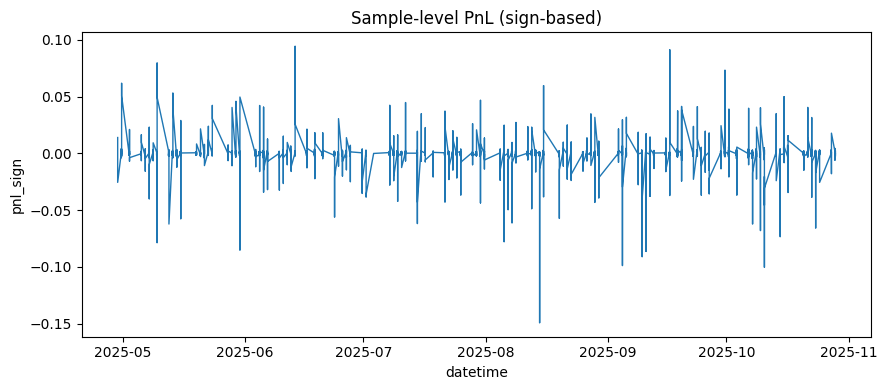

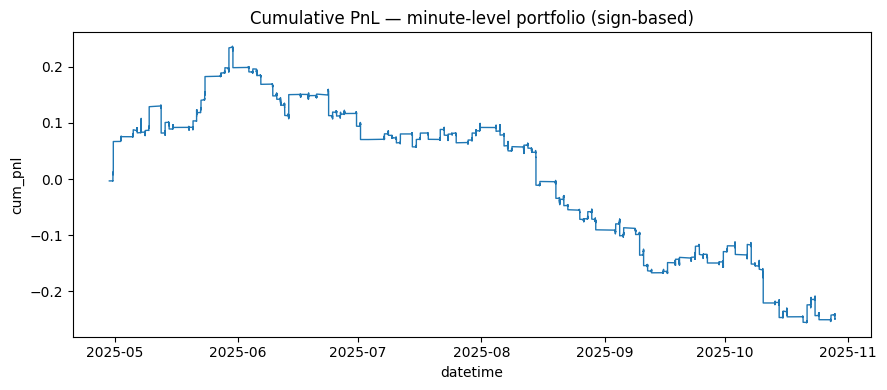

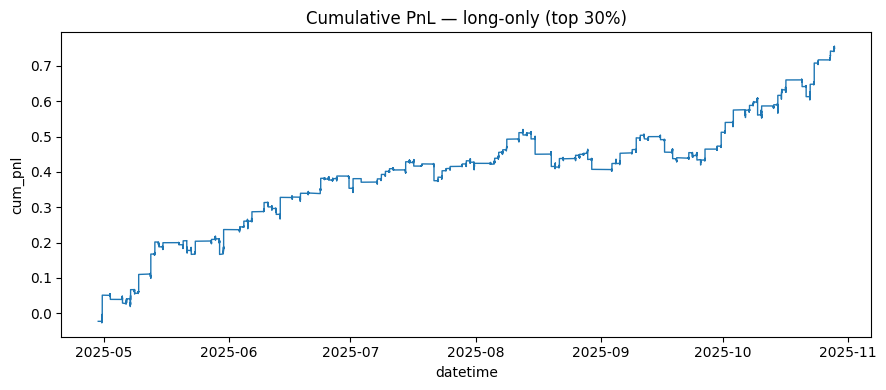

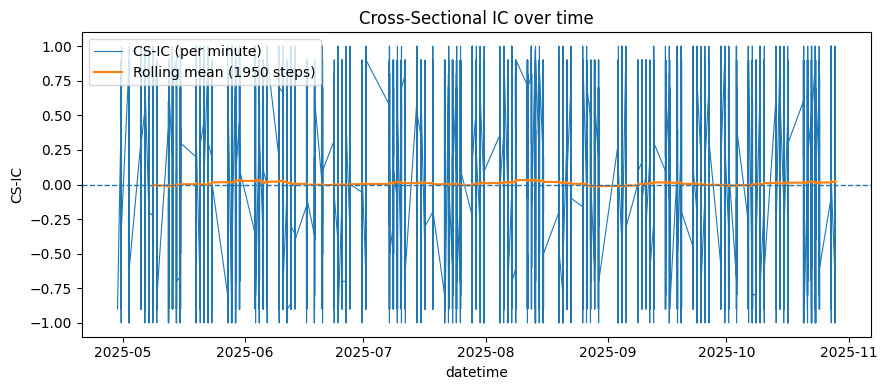

In [160]:
# ------------- 5) 画图（3 张）-------------
# 说明：下面三张图帮助直观判断“像不像白噪声”“是否有持续正区间”。

# (1) 你的 sign 策略样本级 PnL（类似你之前那张图），再补一条分钟级组合 PnL 的累积曲线
plt.figure(figsize=(9, 4))
plt.plot(df["datetime"], df["pnl_sign"], linewidth=1)
plt.title("Sample-level PnL (sign-based)")
plt.xlabel("datetime")
plt.ylabel("pnl_sign")
plt.tight_layout()
plt.show()

# 分钟级组合 PnL 的累计曲线（更接近组合级别表现）
cum_pnl_minute = pnl_sign_minute.cumsum()
plt.figure(figsize=(9, 4))
plt.plot(cum_pnl_minute.index, cum_pnl_minute.values, linewidth=1)
plt.title("Cumulative PnL — minute-level portfolio (sign-based)")
plt.xlabel("datetime")
plt.ylabel("cum_pnl")
plt.tight_layout()
plt.show()

# (2) long-only relative 的分钟级累计收益
cum_pnl_lo = pnl_lo_minute.cumsum()
plt.figure(figsize=(9, 4))
plt.plot(cum_pnl_lo.index, cum_pnl_lo.values, linewidth=1)
plt.title(f"Cumulative PnL — long-only (top {int((1-TOP_Q)*100)}%)")
plt.xlabel("datetime")
plt.ylabel("cum_pnl")
plt.tight_layout()
plt.show()

# (3) 横截面 IC（原始 + 滚动）
plt.figure(figsize=(9, 4))
plt.plot(ic_cs_series.index, ic_cs_series.values, linewidth=0.8, label="CS-IC (per minute)")
plt.plot(ic_cs_roll.index, ic_cs_roll.values, linewidth=1.5, label=f"Rolling mean ({ROLL_MIN} steps)")
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.title("Cross-Sectional IC over time")
plt.xlabel("datetime")
plt.ylabel("CS-IC")
plt.legend()
plt.tight_layout()
plt.show()

In [161]:
# ------------- 6) 结果小结（打印在控制台）-------------
print("\n=== [Summary] ===")
print(f"Overall IC (sample-wise): {ic_overall:.6f}")
print(f"CS-IC mean (minute-wise): {ic_cs_series.mean():.6f}")
print(f"Sharpe sign — sample-level: {sharpe_sign_sample:.6f} | annualized: {sharpe_sign_sample_ann:.6f}")
print(f"Sharpe sign — minute-portfolio: {sharpe_sign_minute:.6f} | annualized: {sharpe_sign_minute_ann:.6f}")
print(f"Sharpe long-only (minute): {sharpe_lo:.6f} | annualized: {sharpe_lo_ann:.6f}")


=== [Summary] ===
Overall IC (sample-wise): 0.003654
CS-IC mean (minute-wise): 0.008353
Sharpe sign — sample-level: -0.005751 | annualized: -1.802984
Sharpe sign — minute-portfolio: -0.008788 | annualized: -2.754892
Sharpe long-only (minute): 0.020691 | annualized: 6.486698
